# Patient's Stroke Prediction


In [36]:
# Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Model Selection and Classification Model
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures

# Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import fbeta_score
from sklearn.metrics import RocCurveDisplay
from sklearn.feature_selection import SelectFromModel
import pickle

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Save model
import joblib

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# SMOTE
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.utils import shuffle


# # # Mount Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Set max columns
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_columns', None)

# Load Dataset

In [2]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [3]:
df.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

In [4]:
df.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [5]:
df.duplicated().sum()

0

# EDA

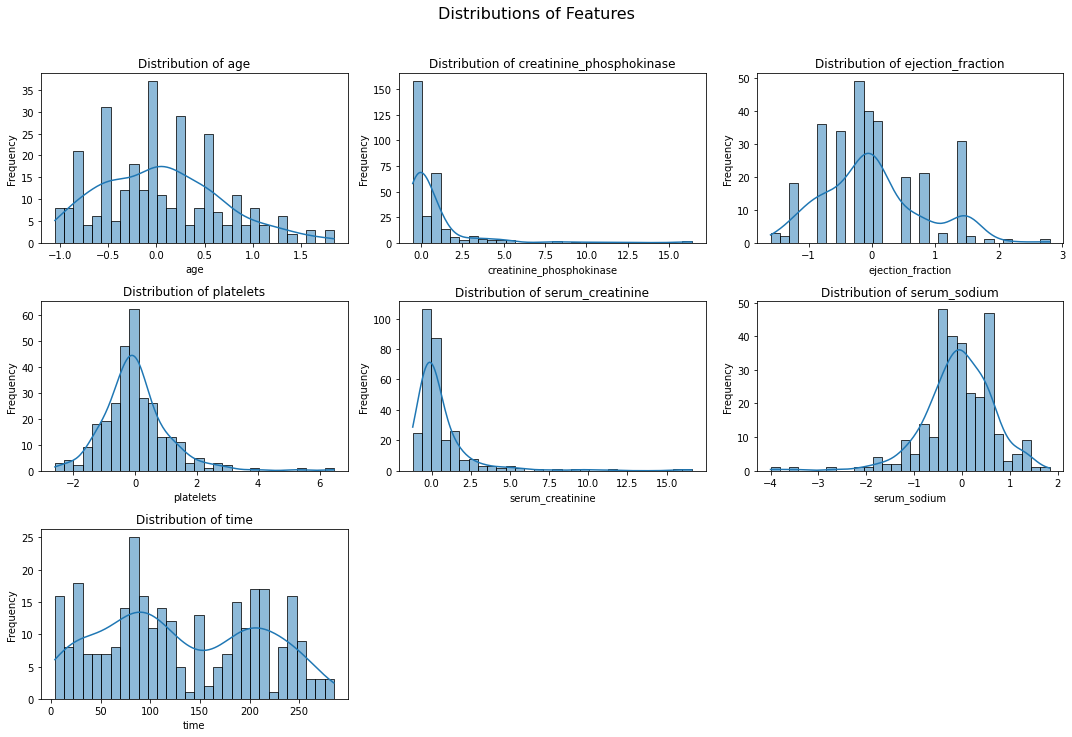

In [51]:
# List of numerical features
numerical_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']

# Create subplots for each feature
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)  # 3 rows, 3 columns of subplots
    sns.histplot(data=df, x=feature, kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

# Add a main title for the entire figure
plt.suptitle('Distributions of Features', fontsize=16, y=1.02)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

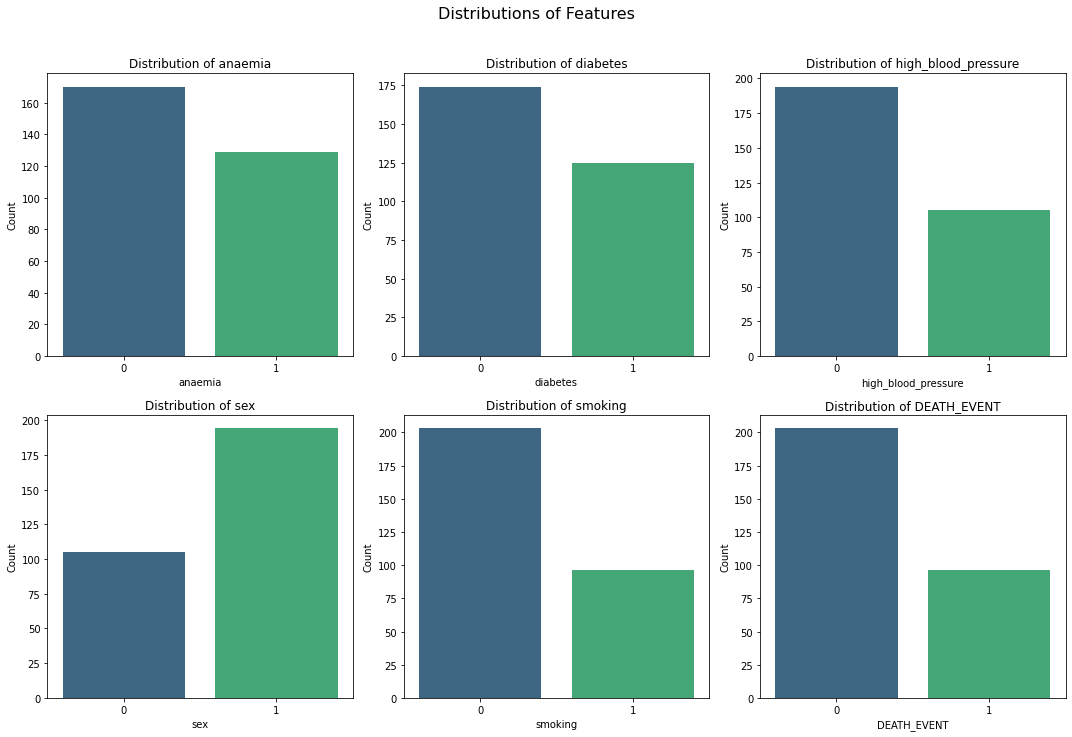

In [49]:
# List of features to plot
features = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT']

# Create subplots for each feature
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)  # 2 rows, 3 columns of subplots
    sns.countplot(data=df, x=feature, palette='viridis')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')

# Add a main title for the entire figure
plt.suptitle('Distributions of Features', fontsize=16, y=1.02)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

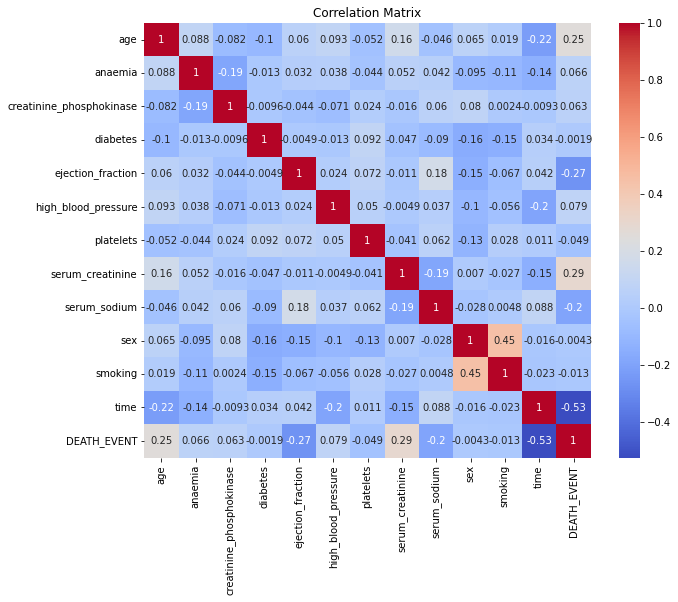

In [7]:
# Heatmap Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

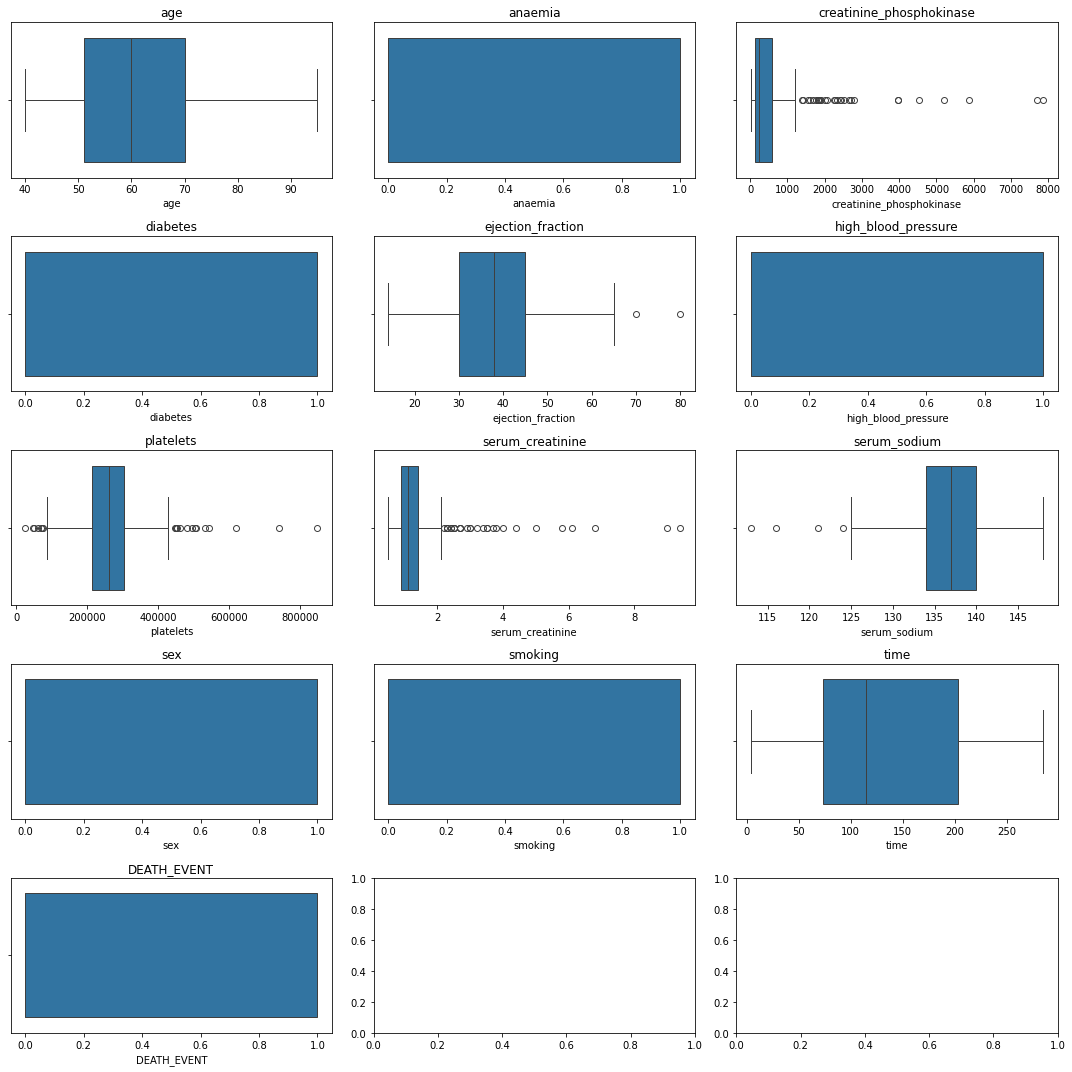

In [8]:
# Visual for outlier of all columns
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
for i, column in enumerate(df.columns):
    row = i // 3
    col = i % 3
    sns.boxplot(x=df[column], ax=axes[row, col])
    axes[row, col].set_title(column)
plt.tight_layout()
plt.show()


# Define X and y

In [9]:
X = df.drop(['DEATH_EVENT', 'time'], axis=1)
y = df['DEATH_EVENT']
X.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0


In [10]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: DEATH_EVENT, dtype: int64

In [11]:
display(df['DEATH_EVENT'].value_counts()/len(df))
display(df['DEATH_EVENT'].value_counts())

DEATH_EVENT
0    0.67893
1    0.32107
Name: count, dtype: float64

DEATH_EVENT
0    203
1     96
Name: count, dtype: int64

# Data Preparation

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

In [13]:
scaler = RobustScaler()
df[['age', 'creatinine_phosphokinase', 'platelets', 'serum_creatinine', 'serum_sodium', 'ejection_fraction']] = scaler.fit_transform(
    df[['age', 'creatinine_phosphokinase', 'platelets', 'serum_creatinine', 'serum_sodium', 'ejection_fraction']]
)


# Model Selection & Cross Validation

In [14]:
logreg = LogisticRegression(max_iter=1000, random_state=42)
dt = DecisionTreeClassifier(random_state=42)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
voting = VotingClassifier(estimators=[('logreg', logreg), ('dt', dt), ('knn', knn), ('rf', rf), ('ada', ada), ('gb', gb)], voting='soft')
stacking = StackingClassifier(estimators=[('logreg', logreg), ('dt', dt), ('knn', knn), ('rf', rf), ('ada', ada), ('gb', gb)], final_estimator=LogisticRegression())

smote = SMOTE(sampling_strategy='auto', random_state=42)


In [15]:
list_model = [logreg, dt, knn, rf, ada, gb, voting, stacking]
model_names = ['Logistic Regression', 'Decision Tree', 'K-Nearest Neighbors',
               'Random Forest', 'AdaBoost', 'Gradient Boosting', 'Voting', 'Stacking']
scoring = 'f1'
list_all_score = []
list_mean_score = []
list_std = []

# Cross-validation loop
for model, name in zip(list_model, model_names):

    # Create pipeline with preprocessing and model
    pipe_prep_model_initial = Pipeline([
        ('preprocessing', scaler),
        ('smote', smote),
        ('modeling', model)
    ])

    # Perform cross-validation
    crossval = cross_val_score(pipe_prep_model_initial, X_train, y_train, cv=5, scoring=scoring, n_jobs=1)

    # Store results
    list_all_score.append(crossval.round(2))
    list_mean_score.append(crossval.mean())
    list_std.append(crossval.std())

    # Print results for each model
    print(f'{name}: Mean {scoring} = {crossval.mean():.4f}, Std = {crossval.std():.4f}')

Logistic Regression: Mean f1 = 0.6074, Std = 0.0848
Decision Tree: Mean f1 = 0.4737, Std = 0.0964
K-Nearest Neighbors: Mean f1 = 0.5804, Std = 0.0584
Random Forest: Mean f1 = 0.6033, Std = 0.0377
AdaBoost: Mean f1 = 0.5850, Std = 0.0848
Gradient Boosting: Mean f1 = 0.5683, Std = 0.0915
Voting: Mean f1 = 0.5960, Std = 0.1041
Stacking: Mean f1 = 0.6204, Std = 0.0900


In [16]:
df_initial = pd.DataFrame()
df_initial['algorithm_model'] = list_model
df_initial['all_acc_score'] = list_all_score
df_initial['mean_acc_score'] = list_mean_score
df_initial['std_score'] = list_std

df_initial.sort_values(by = 'mean_acc_score', ascending=False)

,algorithm_model,all_acc_score,mean_acc_score,std_score
7,"StackingClassifier(estimators=[('logreg',\n ...","[0.5, 0.55, 0.76, 0.67, 0.62]",0.620402,0.089977
0,"LogisticRegression(max_iter=1000, random_state...","[0.47, 0.67, 0.69, 0.67, 0.55]",0.607375,0.084848
3,RandomForestClassifier(random_state=42),"[0.53, 0.6, 0.62, 0.64, 0.62]",0.603315,0.037651
6,"VotingClassifier(estimators=[('logreg',\n ...","[0.45, 0.52, 0.71, 0.71, 0.59]",0.595988,0.104117
4,AdaBoostClassifier(random_state=42),"[0.56, 0.52, 0.65, 0.71, 0.48]",0.585024,0.084788
2,KNeighborsClassifier(),"[0.57, 0.48, 0.67, 0.6, 0.58]",0.580378,0.058376
5,GradientBoostingClassifier(random_state=42),"[0.47, 0.52, 0.69, 0.67, 0.5]",0.568301,0.091516
1,DecisionTreeClassifier(random_state=42),"[0.31, 0.41, 0.55, 0.55, 0.54]",0.473651,0.096400


In [17]:
df_initial = pd.DataFrame()
df_initial['algorithm_model'] = list_model
df_initial['all_rec_score'] = list_all_score
df_initial['mean_rec_score'] = list_mean_score
df_initial['std_score'] = list_std

df_initial.sort_values(by = 'mean_rec_score', ascending=False)

,algorithm_model,all_rec_score,mean_rec_score,std_score
7,"StackingClassifier(estimators=[('logreg',\n ...","[0.5, 0.55, 0.76, 0.67, 0.62]",0.620402,0.089977
0,"LogisticRegression(max_iter=1000, random_state...","[0.47, 0.67, 0.69, 0.67, 0.55]",0.607375,0.084848
3,RandomForestClassifier(random_state=42),"[0.53, 0.6, 0.62, 0.64, 0.62]",0.603315,0.037651
6,"VotingClassifier(estimators=[('logreg',\n ...","[0.45, 0.52, 0.71, 0.71, 0.59]",0.595988,0.104117
4,AdaBoostClassifier(random_state=42),"[0.56, 0.52, 0.65, 0.71, 0.48]",0.585024,0.084788
2,KNeighborsClassifier(),"[0.57, 0.48, 0.67, 0.6, 0.58]",0.580378,0.058376
5,GradientBoostingClassifier(random_state=42),"[0.47, 0.52, 0.69, 0.67, 0.5]",0.568301,0.091516
1,DecisionTreeClassifier(random_state=42),"[0.31, 0.41, 0.55, 0.55, 0.54]",0.473651,0.096400


In [18]:
df_initial = pd.DataFrame()
df_initial['algorithm_model'] = list_model
df_initial['all_pre_score'] = list_all_score
df_initial['mean_pre_score'] = list_mean_score
df_initial['std_score'] = list_std

df_initial.sort_values(by = 'mean_pre_score', ascending=False)

,algorithm_model,all_pre_score,mean_pre_score,std_score
7,"StackingClassifier(estimators=[('logreg',\n ...","[0.5, 0.55, 0.76, 0.67, 0.62]",0.620402,0.089977
0,"LogisticRegression(max_iter=1000, random_state...","[0.47, 0.67, 0.69, 0.67, 0.55]",0.607375,0.084848
3,RandomForestClassifier(random_state=42),"[0.53, 0.6, 0.62, 0.64, 0.62]",0.603315,0.037651
6,"VotingClassifier(estimators=[('logreg',\n ...","[0.45, 0.52, 0.71, 0.71, 0.59]",0.595988,0.104117
4,AdaBoostClassifier(random_state=42),"[0.56, 0.52, 0.65, 0.71, 0.48]",0.585024,0.084788
2,KNeighborsClassifier(),"[0.57, 0.48, 0.67, 0.6, 0.58]",0.580378,0.058376
5,GradientBoostingClassifier(random_state=42),"[0.47, 0.52, 0.69, 0.67, 0.5]",0.568301,0.091516
1,DecisionTreeClassifier(random_state=42),"[0.31, 0.41, 0.55, 0.55, 0.54]",0.473651,0.096400


In [19]:
df_initial = pd.DataFrame()
df_initial['algorithm_model'] = list_model
df_initial['all_f1_score'] = list_all_score
df_initial['mean_f1_score'] = list_mean_score
df_initial['std_score'] = list_std

df_initial.sort_values(by = 'mean_f1_score', ascending=False)

,algorithm_model,all_f1_score,mean_f1_score,std_score
7,"StackingClassifier(estimators=[('logreg',\n ...","[0.5, 0.55, 0.76, 0.67, 0.62]",0.620402,0.089977
0,"LogisticRegression(max_iter=1000, random_state...","[0.47, 0.67, 0.69, 0.67, 0.55]",0.607375,0.084848
3,RandomForestClassifier(random_state=42),"[0.53, 0.6, 0.62, 0.64, 0.62]",0.603315,0.037651
6,"VotingClassifier(estimators=[('logreg',\n ...","[0.45, 0.52, 0.71, 0.71, 0.59]",0.595988,0.104117
4,AdaBoostClassifier(random_state=42),"[0.56, 0.52, 0.65, 0.71, 0.48]",0.585024,0.084788
2,KNeighborsClassifier(),"[0.57, 0.48, 0.67, 0.6, 0.58]",0.580378,0.058376
5,GradientBoostingClassifier(random_state=42),"[0.47, 0.52, 0.69, 0.67, 0.5]",0.568301,0.091516
1,DecisionTreeClassifier(random_state=42),"[0.31, 0.41, 0.55, 0.55, 0.54]",0.473651,0.096400


# Hyperparameter Tuning

In [20]:
# ✅ Step 1: Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ✅ Step 2: Apply SMOTE to Training Data
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# ✅ Step 3: Define Pipeline (WITHOUT SMOTE inside)
pipeline = Pipeline(steps=[
    ('scaling', RobustScaler()),  # Preprocessing step
    ('model', rf)  # Model
])

# ✅ Step 4: Fit the Pipeline with Resampled Data
pipeline.fit(X_train_resampled, y_train_resampled)

# ✅ Step 5: Evaluate the Model
accuracy = pipeline.score(X_test, y_test)
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.7333


# RF Model

In [ ]:
# ✅ Define the Model
rf = RandomForestClassifier(random_state=42)

# ✅ Apply SMOTE Before the Pipeline
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Shuffle the resampled data to avoid bias
X_train_resampled, y_train_resampled = shuffle(X_train_resampled, y_train_resampled, random_state=42)

# ✅ Define the Pipeline (Without SMOTE Inside)
pipeline = Pipeline(steps=[
    ('scaling', RobustScaler()),  # Feature Scaling
    ('model', rf)  # Random Forest Model
])

# Hyperparameter for Random Forest
param_grid = {
    'model__n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
    'model__max_depth': [None, 10, 20, 30, 40, 50],    # Maximum depth of the tree
    'model__min_samples_split': [2, 5, 10],            # Minimum number of samples required to split an internal node
    'model__min_samples_leaf': [1, 2, 4],              # Minimum number of samples required to be at a leaf node
    'model__max_features': ['auto', 'sqrt', 'log2'],   # Number of features to consider when looking for the best split
    'model__bootstrap': [True, False],                 # Whether bootstrap samples are used when building trees
    'model__class_weight': [None, 'balanced', 'balanced_subsample']  # Class imbalance handling
}

# ✅ Perform Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=100,  # Number of different combinations to try (reduced for faster computation)
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # Metric to optimize
    n_jobs=-1,  # Use all CPU cores
    verbose=2,
    random_state=42
)

# ✅ Fit the Model on Resampled Data
random_search.fit(X_train_resampled, y_train_resampled)

# ✅ Best Parameters & Accuracy Score
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy Score:", random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'model__n_estimators': 400, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 10, 'model__class_weight': 'balanced_subsample', 'model__bootstrap': True}
Best Accuracy Score: 0.8209615384615384


In [ ]:
# ✅ Load the Best Model from RandomizedSearchCV
best_model = random_search.best_estimator_

# ✅ Predict on the Test Set
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (heart failure risk)

# ✅ Compute Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# ✅ Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# ✅ Print Metrics
print(f"🔹 Accuracy: {accuracy:.4f}")
print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall: {recall:.4f}")
print(f"🔹 F1 Score: {f1:.4f}")
print(f"🔹 ROC-AUC Score: {roc_auc:.4f}")
print("\n🔹 Confusion Matrix:")
print(conf_matrix)

🔹 Accuracy: 0.7333
🔹 Precision: 0.5882
🔹 Recall: 0.5263
🔹 F1 Score: 0.5556
🔹 ROC-AUC Score: 0.7997

🔹 Confusion Matrix:
[[34  7]
 [ 9 10]]


In [24]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7907    0.8293    0.8095        41
           1     0.5882    0.5263    0.5556        19

    accuracy                         0.7333        60
   macro avg     0.6895    0.6778    0.6825        60
weighted avg     0.7266    0.7333    0.7291        60



# Threshold

In [ ]:
# ✅ Define thresholds to test
thresholds = np.arange(0.1, 1, 0.05)  # Test from 0.1 to 0.55 in steps of 0.05

best_threshold = 0
best_recall = 0
best_f1 = 0

# ✅ Store results for comparison
threshold_results = []

for threshold in thresholds:
    y_pred_adjusted = (y_pred_prob >= threshold).astype(int)  # Adjust threshold
    
    accuracy = accuracy_score(y_test, y_pred_adjusted)
    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    f1 = f1_score(y_test, y_pred_adjusted)
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    # Save the best threshold based on F1-Score or Recall priority
    if f1 > best_f1:
        best_threshold = threshold
        best_recall = recall
        best_f1 = f1

    threshold_results.append((threshold, accuracy, precision, recall, f1, roc_auc))

# ✅ Convert results into a DataFrame for better visualization
import pandas as pd
threshold_df = pd.DataFrame(threshold_results, columns=['Threshold', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])

# ✅ Display best threshold based on recall
print(f"🔹 Best Threshold: {best_threshold} (Recall: {best_recall:.4f}, F1 Score: {best_f1:.4f})")

# ✅ Display results
display(threshold_df)


🔹 Best Threshold: 0.25000000000000006 (Recall: 0.8947, F1 Score: 0.6296)


,Threshold,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,0.10,0.466667,0.372549,1.000000,0.542857,0.799743
1,0.15,0.550000,0.409091,0.947368,0.571429,0.799743
2,0.20,0.600000,0.439024,0.947368,0.600000,0.799743
3,0.25,0.666667,0.485714,0.894737,0.629630,0.799743
4,0.30,0.650000,0.468750,0.789474,0.588235,0.799743
5,0.35,0.683333,0.500000,0.789474,0.612245,0.799743
6,0.40,0.716667,0.538462,0.736842,0.622222,0.799743
7,0.45,0.733333,0.571429,0.631579,0.600000,0.799743
8,0.50,0.733333,0.588235,0.526316,0.555556,0.799743
9,0.55,0.733333,0.600000,0.473684,0.529412,0.799743


In [27]:
optimal_threshold = 0.25
y_pred_final = (y_pred_prob >= optimal_threshold).astype(int)

print(classification_report(y_test, y_pred_final, digits=4))


              precision    recall  f1-score   support

           0     0.9200    0.5610    0.6970        41
           1     0.4857    0.8947    0.6296        19

    accuracy                         0.6667        60
   macro avg     0.7029    0.7279    0.6633        60
weighted avg     0.7825    0.6667    0.6756        60



In [28]:
import pickle

# ✅ Save the trained model
with open("final_rf_model.pkl", "wb") as model_file:
    pickle.dump(best_model, model_file)

# ✅ Save the optimal threshold separately
with open("optimal_threshold_rf.pkl", "wb") as threshold_file:
    pickle.dump(0.4, threshold_file)

print("🎯 Model and threshold saved successfully!")


🎯 Model and threshold saved successfully!


In [ ]:
# ✅ Define Random Forest Model Again
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# ✅ Train the Model (Ensure X_train and y_train are defined)
rf_model.fit(X_train, y_train)

# ✅ Extract Feature Importances
importances = rf_model.feature_importances_

# ✅ Feature Names (Ensure these match your dataset)
feature_names = [
    "age", "anaemia", "creatinine_phosphokinase", "diabetes",
    "ejection_fraction", "high_blood_pressure", "platelets",
    "serum_creatinine", "serum_sodium", "sex", "smoking"
]

# ✅ Create a DataFrame for Feature Importance
rf_feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)
rf_feature_importance_df

,Feature,Importance
7,serum_creatinine,0.231363
4,ejection_fraction,0.190312
2,creatinine_phosphokinase,0.127173
0,age,0.121311
6,platelets,0.109765
8,serum_sodium,0.108152
5,high_blood_pressure,0.025509
1,anaemia,0.023775
10,smoking,0.022285
3,diabetes,0.020448


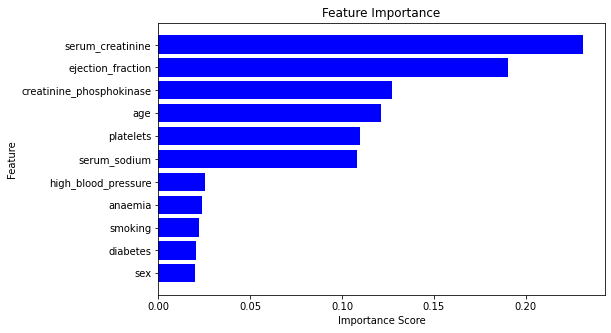

In [38]:
# ✅ Sort features by importance for better visualization
rf_feature_importance_df = rf_feature_importance_df.sort_values(by="Importance", ascending=False)

# ✅ Plot Feature Importance
plt.figure(figsize=(8, 5))
plt.barh(rf_feature_importance_df["Feature"], rf_feature_importance_df["Importance"], color='blue')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()